In [1]:
import lphys
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import awkward as ak
#import scipy
from iminuit import cost, Minuit
from scipy.stats import truncnorm, truncexpon, norm, expon, crystalball
from scipy.special import voigt_profile

We will load two files: one with data, the other with simulation. You can change the datafile to use the electrons dataset instead. You can also change the simulation for the CMS simulation.

In [2]:
# input files
data_file = "doubleMu2011_ntuple.root" # "doubleEl2011_Ntuple.root"
simu_file = "delpheAnalysisZ.root" # "ppNeutralCurrentFullsim_ntuple.root"

In [3]:
datafile = uproot.open(data_file)
simufile = uproot.open(simu_file)
datatree = datafile['LPHY2131analysis/WeakBosonsAnalysis']
simutree = simufile['LPHY2131analysis/WeakBosonsAnalysis']

We take the selection that we obtained previously, and we use it to derive the Invariant Mass distribution.

In [4]:
# Here is an example to start with. Cuts should be tuned and complemented by others.

# cuts
def selection(events, branches=None):
    # first filter on the number of objects
    filter = (events.nMuons==2) & (events.nElectrons==0) & (events.nJets<10)
    selected = events[filter]
    # then apply a cut on the muon Pt
    filter = (selected.MuonsPt[:,0]>10) & (selected.MuonsPt[:,1]>2) 
    selected = selected[filter]
    # cut on the isolation
    filter = (selected.MuonIsolation[:,0]<0.5) & (selected.MuonIsolation[:,1]<0.5) 
    selected = selected[filter]
   
    if branches:
        return selected[branches]
    else:
        return selected

In [5]:
selected_data = lphys.analyzeTree(datatree,["invMass"],selection=selection)
selected_simu = lphys.analyzeTree(simutree,["invMass"],selection=selection)

In [6]:
# This defines the binning for the fit and the display below.
xlim=(40,140)
nbins=100

# the unbinned data
data = ak.to_numpy(selected_data["invMass"]).astype('double')

# the binned data
n, xe = np.histogram(data, bins=nbins, range=xlim) #n: bin content; xe: bin edges
cx = 0.5 * (xe[1:] + xe[:-1]) # bin centers
dx = np.diff(xe) # bin width

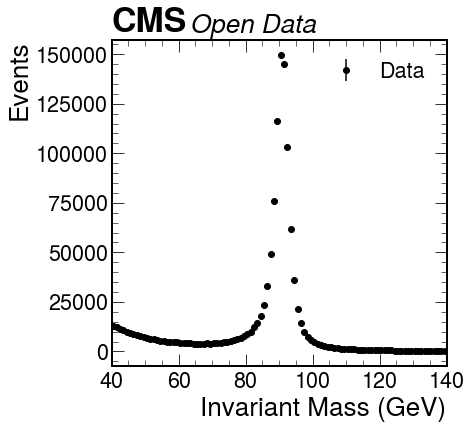

In [7]:
plt.figure(figsize=(6,6))
myplot = lphys.Plotter(None, logscale=False, legend=True, xlabel="Invariant Mass (GeV)", ylabel="Events", fill=True)
myplot(data=(n, xe))

We want to determine the shape of the Z peak, to measure the Z boson mass and width, and the signal purity to get the yield and determine the luminosity.
For that, we will fit the data with 2 components: a signal probability density function (PDF), and a background contribution.

For the background, we could try different things. From the plot above, it seems natural to try one of
- Linear: ```a x + b ```
- Exponential: ```truncexpon.pdf(x, xlim[0], 0, tau) ```
- Gaussian: ```norm.pdf(x, mu, sigma) ```
- ...


For the signal, different options could be tried:
- Gaussian ```norm.pdf(x, mu, sigma) ```
- Normalized relativistic Breit Wigner ```lphys.breitwigner(x, mu, gamma) ```
- Crystalball ```crystalball.pdf(x, beta, m, mu, sigma) ```
- Voigt (Cauchy convoluted with a Gaussian) ```norm.pdf(x, mu, sigma) ```
- ...


See https://docs.scipy.org/doc/scipy/reference/stats.html for more examples of predefined functions.

In [8]:
# background model: exponential
def background_pdf(x,tau):
    return truncexpon.pdf(x, xlim[0], 0, tau)

# signal model: voigt function
def signal_pdf(x,gamma,mu,sigma):
    return voigt_profile(x-mu, sigma, gamma)

From there, we define the total density and the cummulative density function (CDF) for the Extended binned NLL fit.

In [9]:
# There should be no need to change the code below 
# as long as background_pdf and signal_pdf are defined properly above.

# the signal + background density
@lphys.signalbackground(background_pdf,signal_pdf)
def density(x,s,b,bkg_params,signal_params):
    bpdf = background_pdf(x,**bkg_params)
    bpdf = bpdf/bpdf.sum()
    spdf = signal_pdf(x,**signal_params)
    spdf = spdf/spdf.sum()
    return s+b, (b*bpdf)+(s*spdf)
    
# the cummulative distribution
def integral(x, s, b, tau, gamma, mu, sigma):
    return density(**locals())[1].cumsum()

c = cost.ExtendedBinnedNLL(n, xe, integral)

We then do the fit interactively, after setting initial values and allowed ranges for the parameters.

In [10]:
# instantiate the Minuit fitter, with initial values for the parameters. 
# since we will do an interactive fit, this can be adjusted later on.
m = Minuit(c, s=1E6, b=0.5E6, gamma=1, mu=90, sigma=2, tau=35)
# set the allowed ranges for each parameter.
m.limits["s", "b", "tau"] = (0, None)
m.limits["gamma","sigma"] = (0.5,5)
m.limits["mu"] = (60,120)
     
# run the fit !
m.interactive(lphys.Plotter(c,logscale=True, text=False))

Having perfomed the fit, we must study the result in more details.

The first step is to call minos() to get the asymmetric errors on each parameter and the covariance matrix.

In [11]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.532e+04 (chi2/ndof = 163.0)│              Nfcn = 524              │
│ EDM = 1.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  976.3e3  │   1.1e3   │   -1.1e3   │   1.1e3    │    0    │         │       │
│ 1 │ b     │  240.6e3  │   0.7e3   │   -0.7e3   │   0.7e3    │    0    │         │       │
│ 2 │ tau   │   18.65   │   0.08    │   -0.08    │    0.08    │    0    │         │       │
│ 3 │ gamma │   1.670   │   0.006   │   -0.006   │   0.006    │   0.5   │    5    │       │
│ 4 │ mu    │  91.1932  │  0.0030   │  -0.0030   │   0.0030   │   60    │   120   │       │
│ 5 │ sigma │   1.037   │   0.009   │   -0.009   │   0.009    │   0.5   │    5    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           s           │           b           │          tau          │         gamma         │          mu           │         sigma         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -1.1e3   │   1.1e3   │  -0.7e3   │   0.7e3   │   -0.08   │   0.08    │  -0.006   │   0.006   │  -0.003   │   0.003   │  -0.009   │   0.009   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │         s         b       tau     gamma        mu     sigma │
├───────┼─────────────────────────────────────────────────────────────┤
│     s │  1.23e+06 -2.44e+05     -33.7      1.88   -0.0769     -2.08 │
│     b │ -2.44e+05  4.89e+05        31     -1.82    0.0753      2.01 │
│   tau │     -33.7        31   0.00675 -0.000242  8.33e-06  0.000262 │
│ gamma │      1.88     -1.82 -0.000242  3.31e-05   3.6e-07 -4.05e-05 │
│    mu │   -0.0769    0.0753  8.33e-06   3.6e-07  8.92e-06 -2.33e-06 │
│ sigma │     -2.08      2.01  0.000262 -4.05e-05 -2.33e-06  7.48e-05 │
└───────┴─────────────────────────────────────────────────────────────┘

To go more into the details, we can investigate the correlation between the various parameters, and look at the likelihood profile for some parameters. 

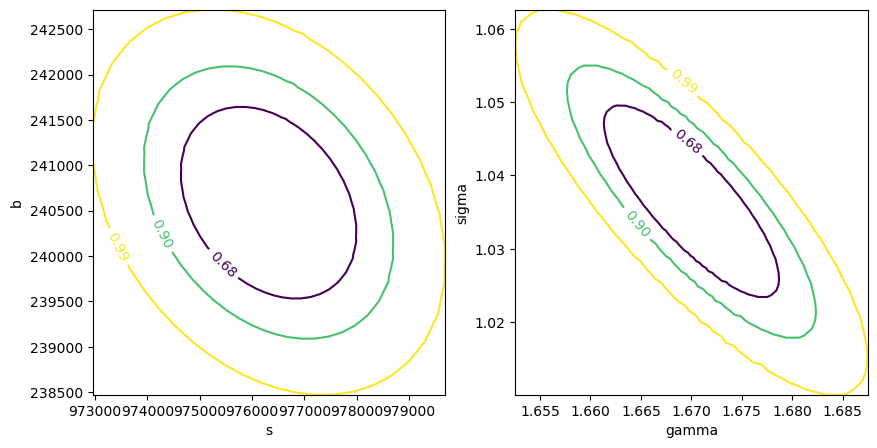

In [12]:
plt.style.use('default')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.axes(axs[0])
m.draw_mncontour("s", "b", cl=(0.68, 0.9, 0.99));
plt.axes(axs[1])
m.draw_mncontour("gamma", "sigma", cl=(0.68, 0.9, 0.99));

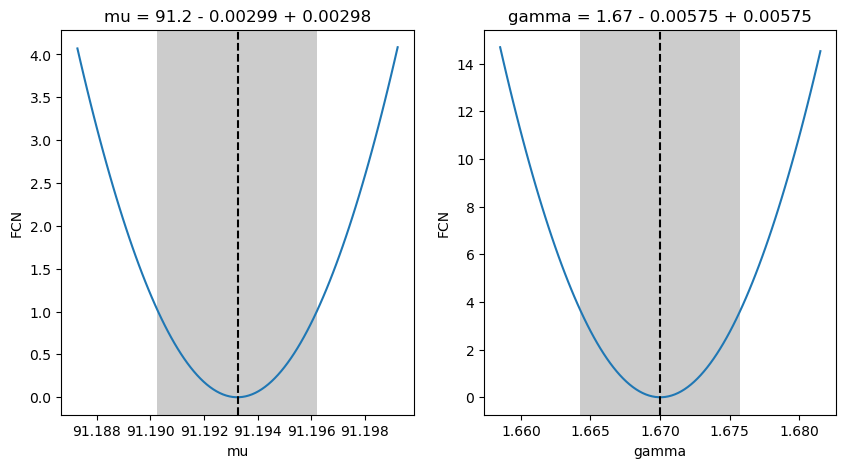

In [13]:
plt.style.use('default')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.axes(axs[0])
m.draw_profile("mu");
plt.axes(axs[1])
m.draw_profile("gamma");

We also produce a publication-ready plot.

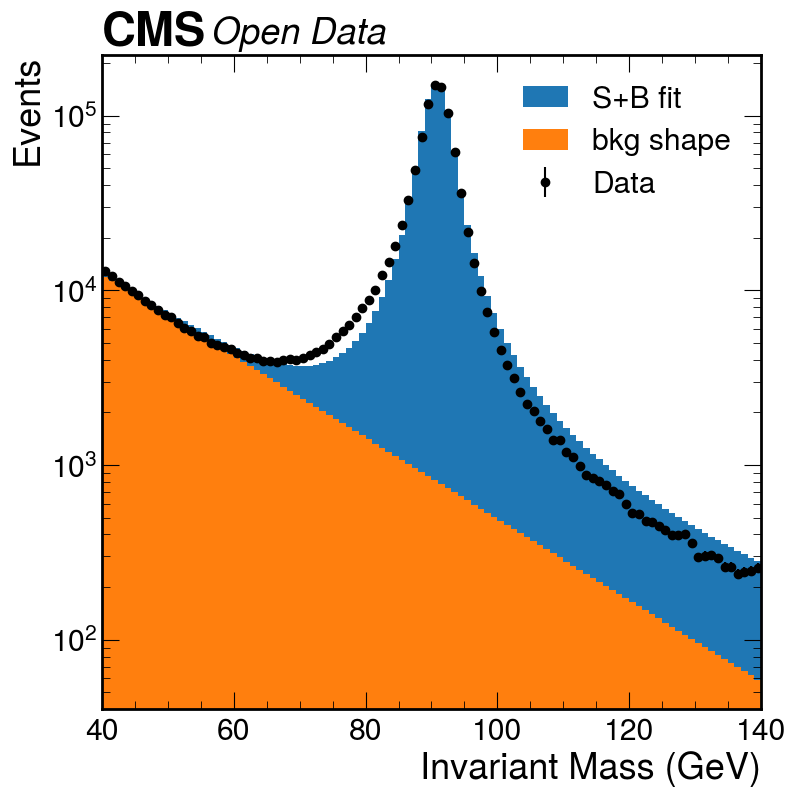

In [14]:
plt.figure(figsize=[8.5,8.5])
lphys.Plotter(c, logscale=True, legend=True, xlabel="Invariant Mass (GeV)", ylabel="Events", fill=True)(m.values)

Before concluding, we should look more closely at the fit results.
Want to extract quantities like the purity or the number of Z bosons, but we are also interested in the uncertainties and correlations, that we can access through the covariance matrix.

Summary data:

Purity as s/N: 48.35 +/- 0.05 %
Purity as (N-b)/N: 88.09 +/- 0.03 %
Purity as s/s+b: 80.23 +/- 0.33 %
Selection efficiency: 33.71 %
N_Z = 976313 +/- 1109
N_bkg = 240586 +/- 700
N_data = 2019411


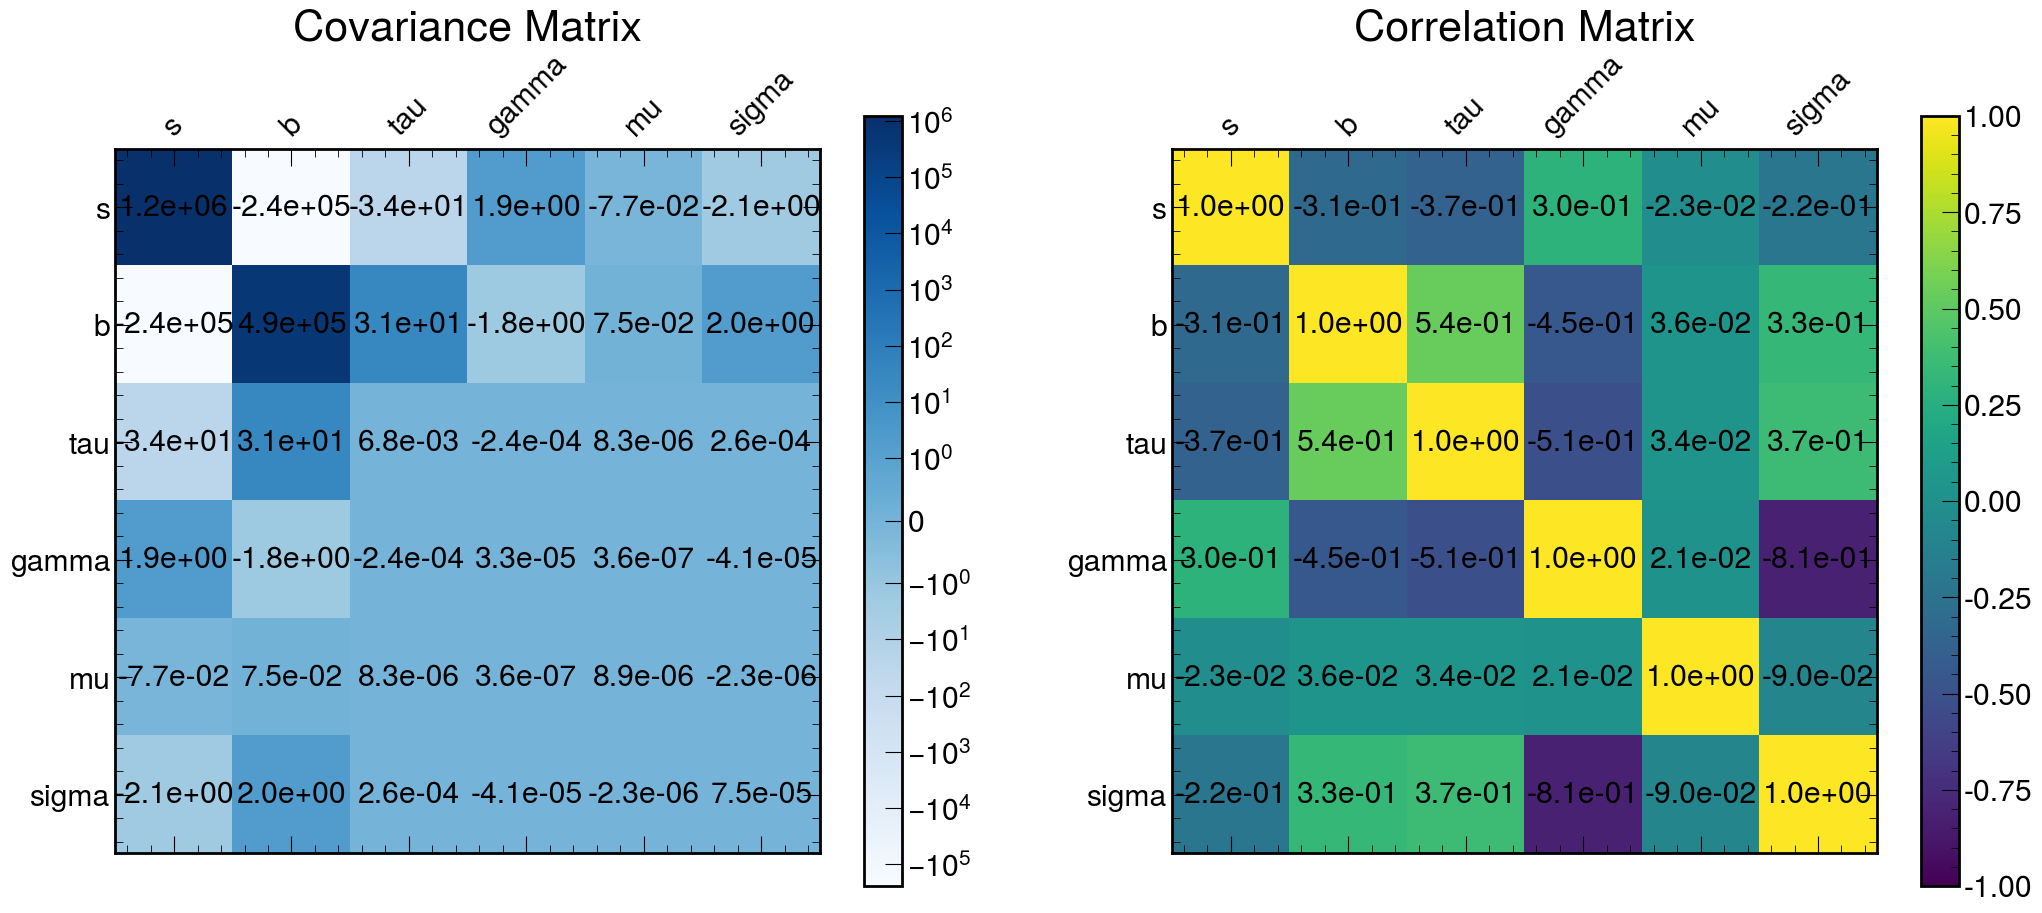

In [15]:
s = m.values['s']
b = m.values['b']
s_unc = m.errors['s']
b_unc = m.errors['b']
N = len(selected_data)
print("Summary data:\n")
print(f"Purity as s/N: { s/N*100:.2f} +/- {s_unc/N*100:.2f} %")
print(f"Purity as (N-b)/N: { (N-b)/N*100:.2f} +/- {b_unc/N*100:.2f} %")
print(f"Purity as s/s+b: {s/(s+b)*100:.2f} +/- {np.sqrt(2*(s_unc/s)**2+(b_unc/b)**2)*100:.2f} %")
print(f"Selection efficiency: {len(selected_simu)/simutree.num_entries*100} %")
print(f"N_Z = {s:.0f} +/- {s_unc:.0f}")
print(f"N_bkg = {b:.0f} +/- {b_unc:.0f}")
print(f"N_data = {N}")

cov = m.covariance
corr = lphys.correlation_from_covariance(cov)
fig, axs = plt.subplots(1, 2,figsize=(25, 10), sharey=False)
lphys.matrixPlot(fig,axs[1],corr,m.parameters,mrange=(-1,1))
lphys.matrixPlot(fig,axs[0],cov,m.parameters,"Blues",mrange="log")
axs[0].set_title('Covariance Matrix')
axs[1].set_title('Correlation Matrix')
plt.show()

We see from the fit above that the functional does not perfectly reproduce the Z lineshape. It would be dangerous to use that fit to extract the yield.

A better approach might be to use the Monte Carlo, that includes more effects (detector modeling, ISR and FSR radiations, etc.)

We therefore define a new fit that uses template histograms for signal and background.

In [16]:
bkg    = lphys.sample(lphys.randomSample(lambda x: background_pdf(x,m.values["tau"]),xlim,nbins,size=10000),
                      "background","C1",integral=m.values["b"])
signal = lphys.sample(selected_simu["invMass"],
                      "signal MC","C0",integral= m.values["s"])

s_histo,bin_edges = np.histogram(ak.to_numpy(signal.events), bins=nbins, range=xlim, density=False ) 
b_histo,bin_edges = np.histogram(ak.to_numpy(bkg.events),bins=nbins, range=xlim, density=False )

In [17]:
c = cost.Template(n, xe, (s_histo,b_histo), ("s","b"))

In [18]:
m = Minuit(c,1e6,5e5)

In [19]:
m.limits = (0, None)
m.interactive()

In [20]:
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 282.2 (chi2/ndof = 2.9)    │              Nfcn = 81               │
│ EDM = 6.54e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s    │  1.034e6  │  0.018e6  │            │            │    0    │         │       │
│ 1 │ b    │   185e3   │    5e3    │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        s        b │
├───┼───────────────────┤
│ s │ 3.32e+08  2.7e+06 │
│ b │  2.7e+06 2.64e+07 │
└───┴───────────────────┘

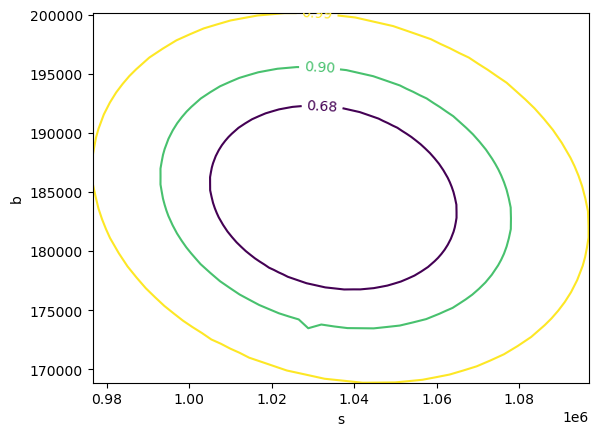

In [21]:
plt.style.use('default')
m.draw_mncontour("s", "b", cl=(0.68, 0.9, 0.99));

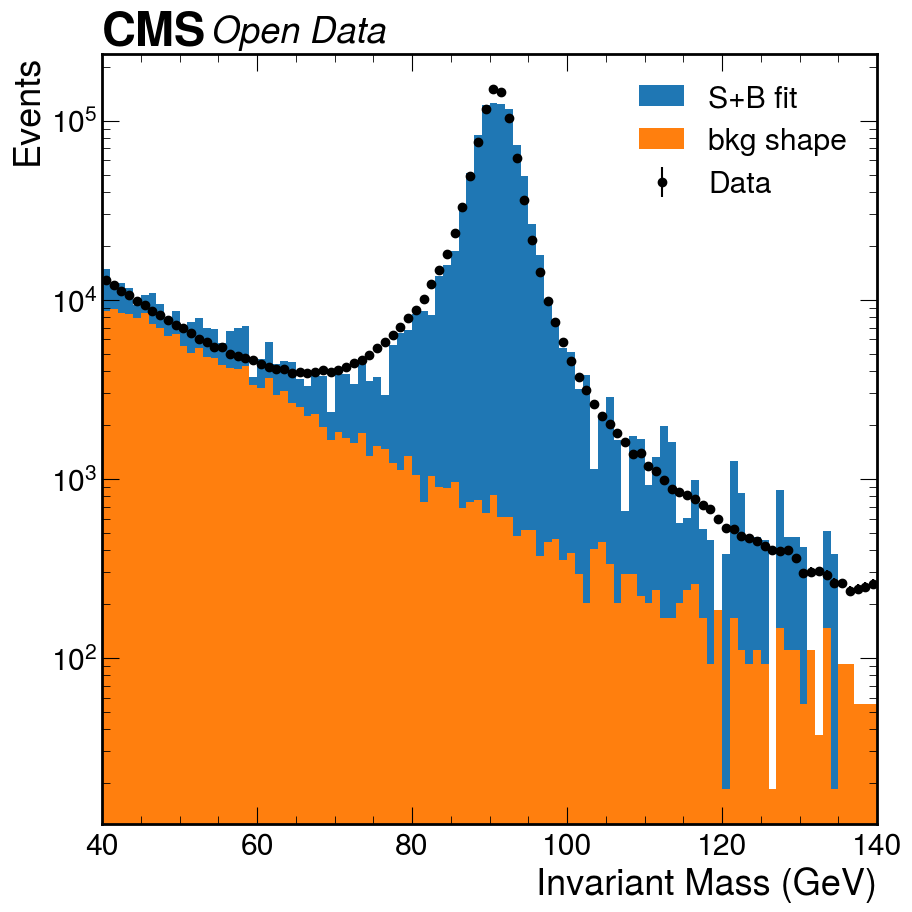

In [22]:
myplot = lphys.Plotter(c, logscale=True, legend=True, xlabel="Invariant Mass (GeV)", ylabel="Events", fill=True)
myplot(m.values)

Summary data:

Purity as s/N: 51.22 +/- 0.90 %
Purity as (N-b)/N: 90.86 +/- 0.25 %
Purity as s/s+b: 84.86 +/- 3.73 %
Selection efficiency: 33.71 %
N_Z = 1034361 +/- 18227
N_bkg = 184582 +/- 5134
N_data = 2019411


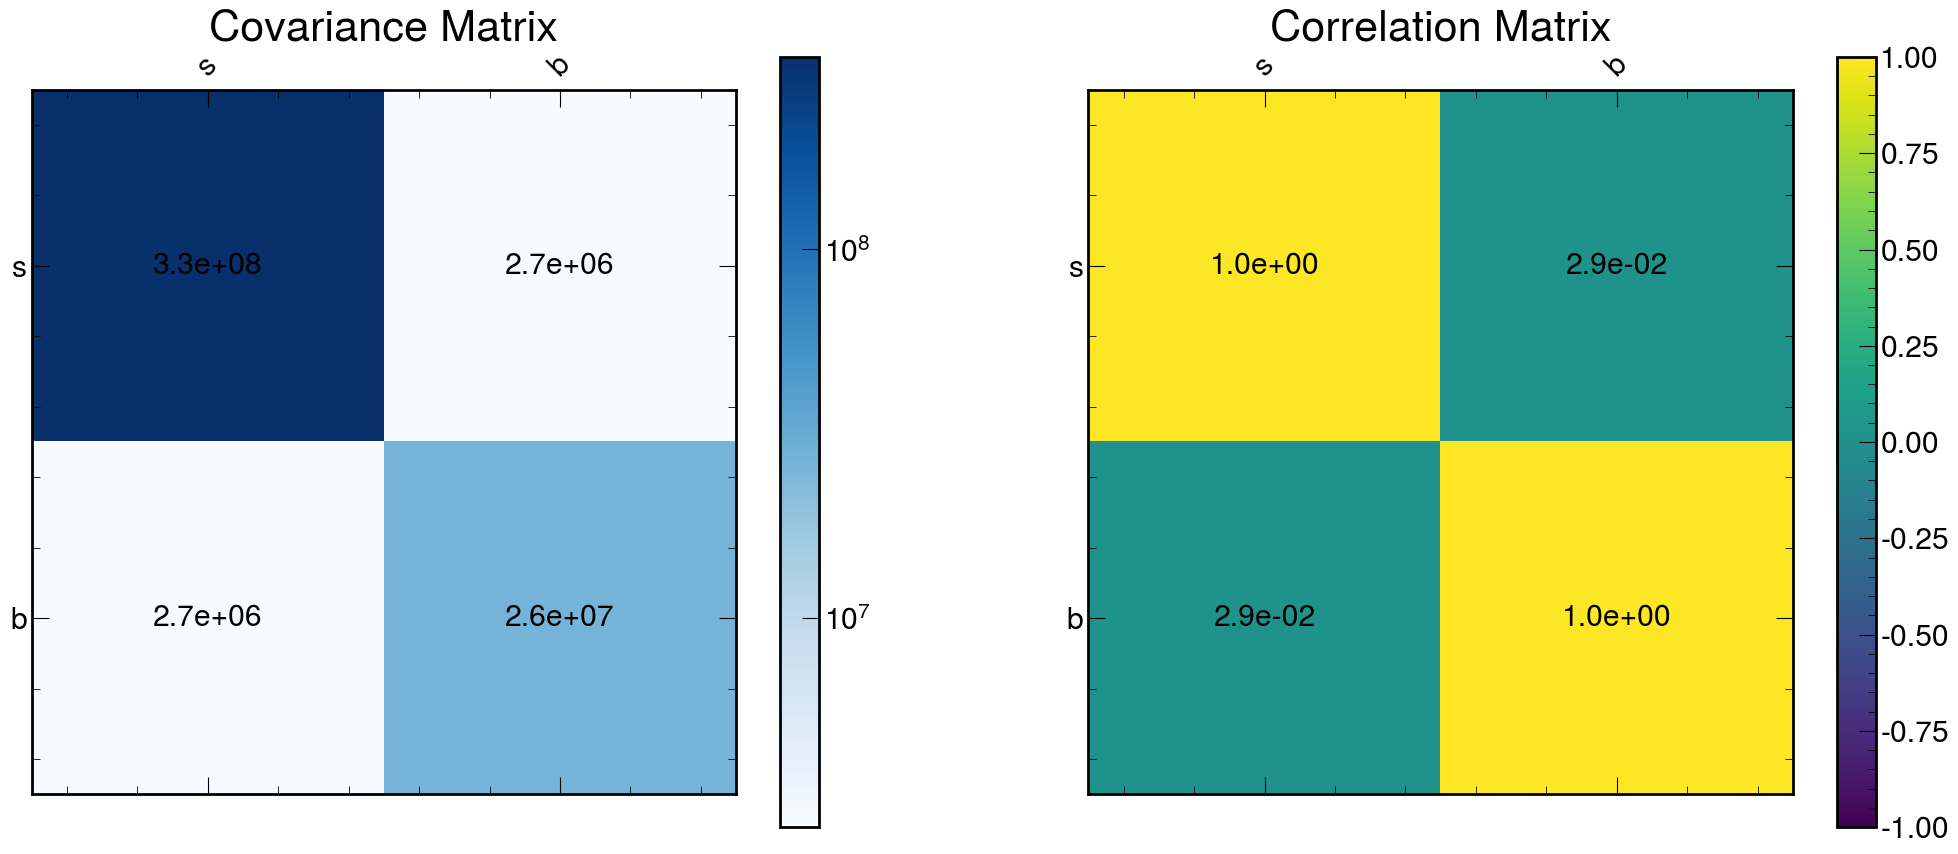

In [23]:
s = m.values['s']
b = m.values['b']
s_unc = m.errors['s']
b_unc = m.errors['b']
N = len(selected_data)
print("Summary data:\n")
print(f"Purity as s/N: { s/N*100:.2f} +/- {s_unc/N*100:.2f} %")
print(f"Purity as (N-b)/N: { (N-b)/N*100:.2f} +/- {b_unc/N*100:.2f} %")
print(f"Purity as s/s+b: {s/(s+b)*100:.2f} +/- {np.sqrt(2*(s_unc/s)**2+(b_unc/b)**2)*100:.2f} %")
print(f"Selection efficiency: {len(selected_simu)/simutree.num_entries*100} %")
print(f"N_Z = {s:.0f} +/- {s_unc:.0f}")
print(f"N_bkg = {b:.0f} +/- {b_unc:.0f}")
print(f"N_data = {N}")

cov = m.covariance
corr = lphys.correlation_from_covariance(cov)
fig, axs = plt.subplots(1, 2,figsize=(25, 10), sharey=False)
lphys.matrixPlot(fig,axs[1],corr,m.parameters,mrange=(-1,1))
lphys.matrixPlot(fig,axs[0],cov,m.parameters,"Blues",mrange="log")
axs[0].set_title('Covariance Matrix')
axs[1].set_title('Correlation Matrix')
plt.show()